# Install Library
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats
from scipy.stats import f_oneway

from IPython.display import display

# **Load Data**

---



In [2]:
df_admission = pd.read_csv('../mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
df_patient = pd.read_csv('../mimic-iii-clinical-database-1.4/PATIENTS.csv')
df_prescription = pd.read_csv('../mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')

/Users/jk/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Define Functions: Plot
---

In [3]:
def countplot(data, column, figsize):
    
    fig, ax = plt.subplots(figsize=figsize)
    
    count_plot = sns.countplot(
        x=column,
        data=data,
        ax=ax
    )

    # Display count for each bar
    count_plot.set_xticklabels(count_plot.get_xticklabels())
    for p in count_plot.patches:
        height = p.get_height()
        count_plot.text(p.get_x()+p.get_width()/2., height + 0.1, height,ha="center")
        
    plt.xticks(rotation=45, ha='right')
    plt.show()

# **Preprocess Data**
---

## **ADMISSIONS.csv**

### Check for missing values

In [4]:
if df_admission.isnull().values.any() == True:
    print('Missing value exists in {}.\n\nThe number of missing values is as follows:\n{}'.format('ADMISSIONS.csv', df_admission.isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists in ADMISSIONS.csv.

The number of missing values is as follows:
ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64


### **ETHNICITY**

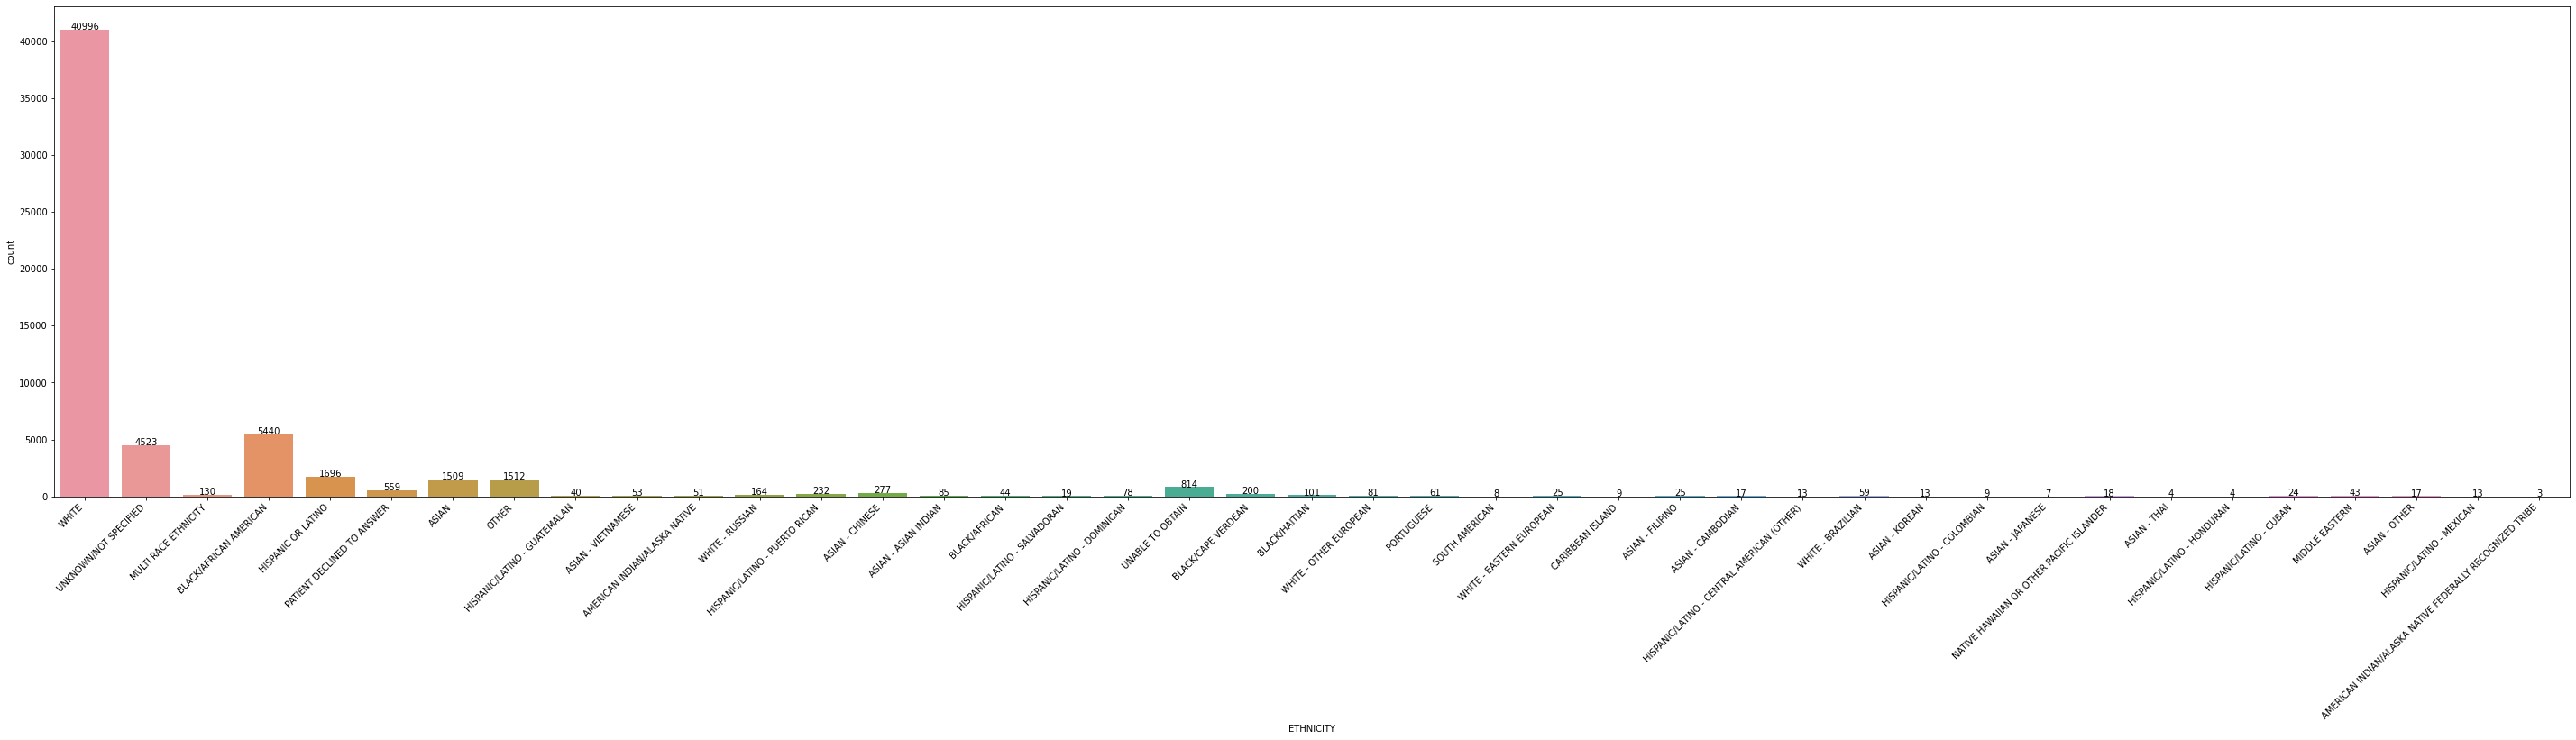

In [5]:
countplot(df_admission, 'ETHNICITY', (50, 10))

#### Rebuild category

In [6]:
df_admission['ETHNICITY'].replace('^WHITE\D*', 'WHITE', regex=True, inplace=True)
df_admission['ETHNICITY'].replace('^BLACK\D*', 'BLACK/AFRICAN AMERICAN', regex=True, inplace=True)
df_admission['ETHNICITY'].replace('^HISPANIC\D*', 'HISPANIC/LATINO', regex=True, inplace=True)
df_admission['ETHNICITY'].replace('^ASIAN\D*', 'ASIAN', regex=True, inplace=True)
df_admission.loc[~df_admission['ETHNICITY'].isin(['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN']), 'ETHNICITY'] = 'UNKNOWN/NOT SPECIFIED'

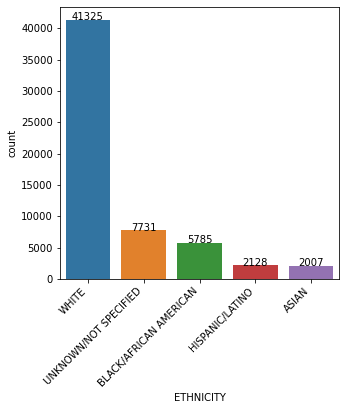

In [7]:
#value = df_admission.ETHNICITY.values
#label = df_admission.ETHNICITY.unique()
countplot(df_admission, 'ETHNICITY', (5, 5))

In [8]:
ls_ethnicity = list(df_admission['ETHNICITY'].unique())
ls_ethnicity_sub = ls_ethnicity.copy()
ls_ethnicity_sub.remove('UNKNOWN/NOT SPECIFIED')

### **ADMISSION_TYPE**

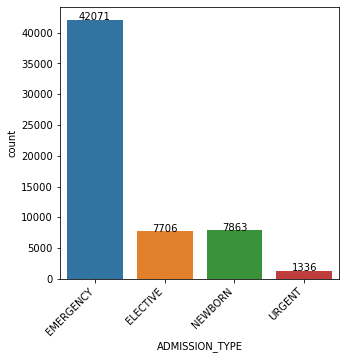

In [9]:
countplot(df_admission, 'ADMISSION_TYPE', (5, 5))

#### Rebuild category

ADMISSION_TYPE describes the type of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’. Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies. Elective indicates a previously planned hospital admission. Newborn indicates that the HADM_ID pertains to the patient’s birth.

In [10]:
df_admission['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY', inplace=True)

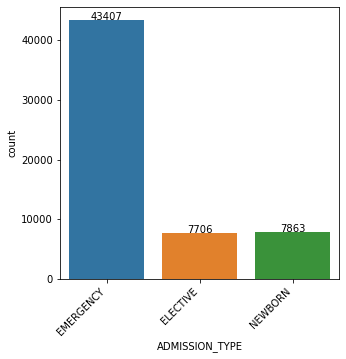

In [11]:
countplot(df_admission, 'ADMISSION_TYPE', (5, 5))

### **MARITAL_STATUS**

#### Impute missing values

In [12]:
df_admission['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)', inplace=True)

# Confirm the completion of the imputation
if df_admission['MARITAL_STATUS'].isnull().values.any() == False:
    print('All missing values are imputed')

All missing values are imputed


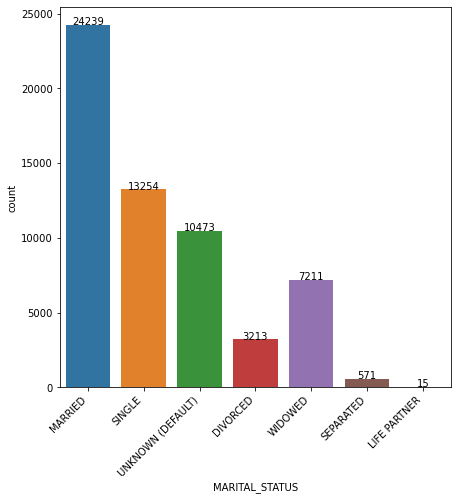

In [13]:
countplot(df_admission, 'MARITAL_STATUS', (7, 7))

#### Rebuild category

In [14]:
df_admission.MARITAL_STATUS.replace('WIDOWED', 'SINGLE', inplace=True)
df_admission.MARITAL_STATUS.replace('DIVORCED', 'SINGLE', inplace=True)
df_admission.MARITAL_STATUS.replace('SEPARATED', 'UNKNOWN (DEFAULT)', inplace=True)
df_admission.MARITAL_STATUS.replace('LIFE PARTNER', 'UNKNOWN (DEFAULT)', inplace=True)

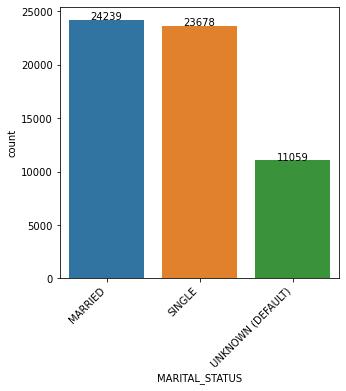

In [15]:
countplot(df_admission, 'MARITAL_STATUS', (5, 5))

### **RELIGION**

#### Impute missing values

In [16]:
df_admission['RELIGION'].fillna('UNOBTAINABLE', inplace=True)

# Confirm the completion of the imputation
if df_admission['RELIGION'].isnull().values.any() == False:
    print('All missing values are imputed')

All missing values are imputed


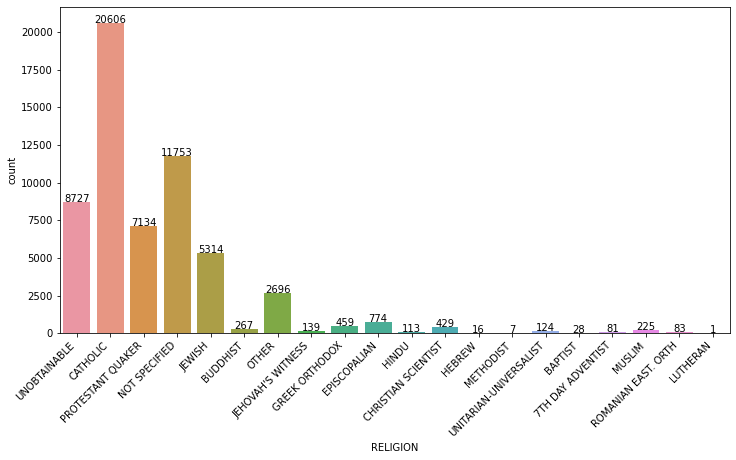

In [17]:
countplot(df_admission, 'RELIGION', (12,6))

#### Rebuild category

In [18]:
df_admission.loc[~df_admission['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE']), 'RELIGION'] = 'RELIGIOUS'
df_admission.loc[df_admission['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE']), 'RELIGION'] = 'UNKNOWN'

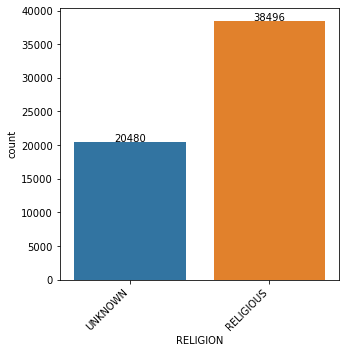

In [19]:
countplot(df_admission, 'RELIGION', (5, 5))

### **INSURANCE**

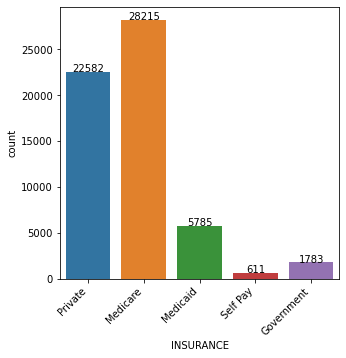

In [20]:
countplot(df_admission, 'INSURANCE', (5, 5))

### Generate new dataframe

The new datafram is grouped by patients with top 10 diagnoses from ADMISSIONS

In [21]:
# List of top 10 diagnoses based on the number of patients for each diagnosis
ls_diagnoses_10 = list(df_admission['DIAGNOSIS'].value_counts()[1:11].keys())

df = df_admission.loc[df_admission['DIAGNOSIS'].isin(ls_diagnoses_10)]
print(df.shape)
df.head()

(8570, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
15,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
18,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1
22,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1
24,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1
25,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1


## PATIENTS.csv

In [22]:
df_patient.info()
df_patient.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [23]:
if df_patient.isnull().values.any() == True:
    print('Missing value exists in {}.\n\nThe number of missing values is as follows:\n{}'.format('PATIENTS.csv', df_patient.isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists in PATIENTS.csv.

The number of missing values is as follows:
ROW_ID             0
SUBJECT_ID         0
GENDER             0
DOB                0
DOD            30761
DOD_HOSP       36546
DOD_SSN        33142
EXPIRE_FLAG        0
dtype: int64


### DOB

#### Convert data type

In [24]:
df_patient['DOB'] = pd.to_datetime(df_patient['DOB'])

### Merge dataframes

In [25]:
df = df.merge(df_patient, how='inner', on='SUBJECT_ID')
print(df.shape)
df.head()

(8570, 26)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,CONGESTIVE HEART FAILURE,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,GASTROINTESTINAL BLEED,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,SEPSIS,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,PNEUMONIA,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1


## Add 'AGE' column

### Generate a dataframe for initial admission date per patient

In [26]:
df_admittime_init = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_admittime_init.columns = ['SUBJECT_ID', 'ADMITTIME_INIT']
df_admittime_init['ADMITTIME_INIT'] = pd.to_datetime(df_admittime_init['ADMITTIME_INIT'])
print(df_admittime_init.shape)
df_admittime_init.head()

(7642, 2)


,SUBJECT_ID,ADMITTIME_INIT
0,13,2167-01-08 18:43:00
1,21,2134-09-11 12:17:00
2,36,2131-04-30 07:15:00
3,37,2183-08-21 16:48:00
4,42,2116-04-26 18:58:00


### Merge dataframes

In [27]:
df = df.merge(df_admittime_init, how='outer', on='SUBJECT_ID')
print(df.shape)
df.head()

(8570, 27)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00


### Calculate age

In [28]:
df['AGE'] = round((df['ADMITTIME_INIT'].sub(df['DOB'], axis=0))/np.timedelta64(1, 'Y'), 0)
print(df.shape)
df.head()

(8570, 28)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT,AGE
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00,70.0
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00,69.0
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0


## Filter abnormal rows

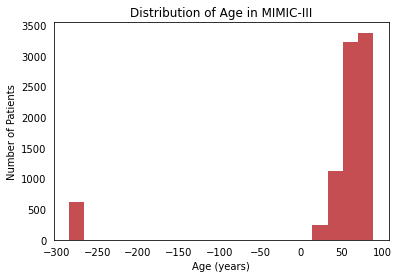

In [29]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['AGE'], bins=20, color='#c44e52')
plt.ylabel('Number of Patients')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

In [30]:
df = df.loc[df['AGE'] >= 0]
print(df.shape)
df.head()

(7956, 28)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT,AGE
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00,70.0
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00,69.0
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0


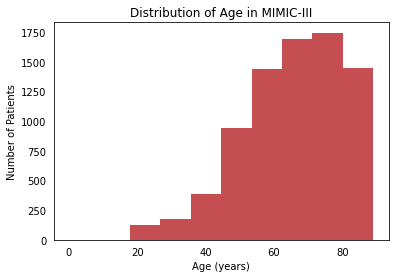

In [31]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['AGE'], bins=10, color='#c44e52')
plt.ylabel('Number of Patients')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

## Rebuild category 

In [32]:
age_range = [(0, 20), (20, 40), (40, 60), (60, 100)]

age_dict = {0: 'minor',
            1: 'young_adult',
            2: 'middle_adult',
            3: 'senior'}

for num, category_range in enumerate(age_range):
    df['AGE'] = np.where(df['AGE'].between(category_range[0], category_range[1]), num, df['AGE'])
    
df['AGE'] = df['AGE'].replace(age_dict)
df['AGE'].value_counts()

senior          5264
middle_adult    2226
young_adult      432
minor             34
Name: AGE, dtype: int64

In [33]:
#df = df.drop(['ADMITTIME', 'DOB', 'ADMITTIME_INIT'], axis=1)
print(df.shape)
df.head()

(7956, 28)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT,AGE
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,...,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00,senior
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00,senior
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,senior
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,senior
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,senior


## Drop unnecessary columns

In [34]:
df = df.drop(['ROW_ID_x', 'SUBJECT_ID', 'ADMITTIME', 'DISCHTIME',
              'DEATHTIME', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'LANGUAGE',
              'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'ROW_ID_y',
              'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ADMITTIME_INIT'], axis=1)

print(df.shape)
df.head()

(7956, 9)


,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE
0,182104,EMERGENCY,Medicare,UNKNOWN,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,senior
1,188670,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,CONGESTIVE HEART FAILURE,M,senior
2,174486,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,GASTROINTESTINAL BLEED,M,senior
3,122609,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,SEPSIS,M,senior
4,101651,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,PNEUMONIA,M,senior


## Generate new data frames of top 10 diagnoses

In [35]:
ls_diagnoses_10

['PNEUMONIA',
 'SEPSIS',
 'CONGESTIVE HEART FAILURE',
 'CORONARY ARTERY DISEASE',
 'CHEST PAIN',
 'INTRACRANIAL HEMORRHAGE',
 'ALTERED MENTAL STATUS',
 'GASTROINTESTINAL BLEED',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA',
 'UPPER GI BLEED']

In [36]:
ls_df_diagnoses = []

for diagnosis in ls_diagnoses_10:
  locals()['df_'+ diagnosis.lower().replace(' ', '_').replace('\\', '_').replace('/', '_').replace('__', '_')] = df.loc[df['DIAGNOSIS'] == diagnosis]
  ls_df_diagnoses.append('df_'+ diagnosis.lower().replace(' ', '_').replace('\\', '_').replace('/', '_').replace('__', '_'))

In [37]:
ls_df_diagnoses

['df_pneumonia',
 'df_sepsis',
 'df_congestive_heart_failure',
 'df_coronary_artery_disease',
 'df_chest_pain',
 'df_intracranial_hemorrhage',
 'df_altered_mental_status',
 'df_gastrointestinal_bleed',
 'df_coronary_artery_disease_coronary_artery_bypass_graft_sda',
 'df_upper_gi_bleed']

## **PRESCRIPTION.csv**

In [38]:
df_prescription.info()
df_prescription.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4156450 entries, 0 to 4156449
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ROW_ID             int64  
 1   SUBJECT_ID         int64  
 2   HADM_ID            int64  
 3   ICUSTAY_ID         float64
 4   STARTDATE          object 
 5   ENDDATE            object 
 6   DRUG_TYPE          object 
 7   DRUG               object 
 8   DRUG_NAME_POE      object 
 9   DRUG_NAME_GENERIC  object 
 10  FORMULARY_DRUG_CD  object 
 11  GSN                object 
 12  NDC                float64
 13  PROD_STRENGTH      object 
 14  DOSE_VAL_RX        object 
 15  DOSE_UNIT_RX       object 
 16  FORM_VAL_DISP      object 
 17  FORM_UNIT_DISP     object 
 18  ROUTE              object 
dtypes: float64(2), int64(3), object(14)
memory usage: 602.5+ MB


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


### Check for missing values

In [39]:
if df_prescription.isnull().values.any() == True:
    print('Missing value exists in {}.\nThe number of missing values is as follows:\n{}'.format('PRESCRIPTIONS.csv', df_prescription.isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists in PRESCRIPTIONS.csv.
The number of missing values is as follows:
ROW_ID                     0
SUBJECT_ID                 0
HADM_ID                    0
ICUSTAY_ID           1447708
STARTDATE               3182
ENDDATE                 5421
DRUG_TYPE                  0
DRUG                       0
DRUG_NAME_POE        1664234
DRUG_NAME_GENERIC    1662989
FORMULARY_DRUG_CD       1933
GSN                   507164
NDC                     4463
PROD_STRENGTH           1362
DOSE_VAL_RX             1350
DOSE_UNIT_RX            1342
FORM_VAL_DISP           1355
FORM_UNIT_DISP          1409
ROUTE                   1156
dtype: int64


### DRUG

In [40]:
for diagnosis in ls_df_diagnoses:
  locals()[diagnosis+'_'] = locals()[diagnosis].merge(df_prescription[['HADM_ID', 'DRUG']], how='inner', on='HADM_ID')

In [41]:
for diagnosis in ls_df_diagnoses:
    # Merge data frames of top 10 diagnoses with data frame of PRESCRIPTIONS
    locals()[diagnosis+'_tmp'] = locals()[diagnosis].merge(df_prescription[['HADM_ID', 'DRUG']], how='inner', on='HADM_ID')
    
    # Create lists of top 10 drugs of each diagnosis
    locals()['top_drug_'+diagnosis] = list(locals()[diagnosis+'_tmp']['DRUG'].value_counts().nlargest(10).keys())
    #locals()['top_drug_'+diagnosis] = list(locals()[diagnosis].merge(df_prescription[['HADM_ID', 'DRUG']], how='inner', on='HADM_ID')['DRUG'].value_counts().nlargest(10).keys())
    
    tmp = locals()[diagnosis+'_tmp'].loc[locals()[diagnosis+'_tmp']['DRUG'].isin(locals()['top_drug_'+diagnosis])]
    tmp_2 = tmp.groupby('HADM_ID')['DRUG'].apply(list).reset_index()
    ls_drug = pd.get_dummies(tmp_2['DRUG'].apply(pd.Series).stack()).sum(level=0)
    tmp_2 = tmp_2.join(ls_drug, how='outer')
    tmp_2.drop(['DRUG'], axis=1, inplace=True)
    locals()[diagnosis] = locals()[diagnosis].merge(tmp_2, how='inner', on='HADM_ID')

In [42]:
df_pneumonia.head()

,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE,0.9% Sodium Chloride,5% Dextrose,D5W,Furosemide,Insulin,Iso-Osmotic Dextrose,Magnesium Sulfate,NS,Potassium Chloride,Vancomycin
0,101651,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,PNEUMONIA,M,senior,0,1,0,0,7,1,0,0,5,1
1,170467,EMERGENCY,Medicare,RELIGIOUS,SINGLE,BLACK/AFRICAN AMERICAN,PNEUMONIA,F,middle_adult,0,0,7,4,0,1,6,16,8,0
2,112077,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,PNEUMONIA,M,senior,4,0,0,0,0,3,3,0,0,3
3,140037,EMERGENCY,Medicare,UNKNOWN,MARRIED,ASIAN,PNEUMONIA,M,senior,0,0,6,1,0,6,1,18,9,0
4,155897,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,PNEUMONIA,F,senior,3,6,0,0,1,2,0,0,0,1


# Define Functions: Analysis
--

In [43]:
def unsampling(df):
    # Oversample the minority class by using SMOTE
    white = df.loc[df['ETHNICITY'] == 'WHITE']
    others = df.loc[(df['ETHNICITY'] == 'BLACK/AFRICAN AMERICAN') | (df['ETHNICITY'] == 'HISPANIC/LATINO') |
                  (df['ETHNICITY'] == 'ASIAN') | (df['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED')]

    white_undersample = resample(
      white,
      replace = False,
      n_samples = len(others),
      random_state=42
    )

    df_undersample = pd.concat([white_undersample, others], axis=0)

    # Display count for each bar
    plt.figure(figsize=(10, 5))
    count_plot = sns.countplot(x='ETHNICITY', data=df_undersample)
    count_plot.set_xticklabels(count_plot.get_xticklabels())
    for p in count_plot.patches:
        height = p.get_height()
        count_plot.text(p.get_x()+p.get_width()/2., height + 0.1, height, ha="center")
    plt.show()

    return df_undersample


def mean_drug_race(df, top_drug):

    df_mean = pd.DataFrame(ls_ethnicity_sub, columns=['ETHNICITY'])

    for drug in top_drug:
        mean_drug = []
        for race in ls_ethnicity_sub:
            mean_drug.append(df.loc[df['ETHNICITY'] == race, drug].mean())   
        df_mean = pd.concat([df_mean, pd.DataFrame(mean_drug, columns=[drug])], axis=1)

    return df_mean


def plot_mean_drug_race(df_mean, top_drug, diagnosis):

    data = []

    for drug in df_mean:
        if drug != 'ETHNICITY':
            data.append(list(df_mean[drug]))

    data = np.array(data)
    length = len(data)
    x_label = top_drug

    fig, ax = plt.subplots(figsize=(30, 10))
    width = 1.0
    x = np.arange(0, length*5, 5)

    ax.bar(x, data[:,0], width, color='#F1948A', label='WHITE')
    ax.bar(x + width, data[:,1], width, color='#F7DC6F', label='BLACK/AFRICAN AMERICAN')
    ax.bar(x + (width*2), data[:,2], width, color='#7DCEA0', label='HISPANIC/LATINO')
    ax.bar(x + (width*3), data[:,3], width, color='#85C1E9', label='ASIAN')

    ax.set_ylabel('Mean of Prescriptions')
    ax.set_ylim(0,10)
    ax.set_xlabel('Top 10 Drugs of '+diagnosis)
    ax.set_xticks(x + width + width/2)
    ax.set_xticklabels(x_label)
    ax.set_title('Prescriptions of '+diagnosis+' per Racial Group')
    ax.legend()

    plt.show()


def statistics_anova(df, top_drug):
    for drug in top_drug:
        print('\n----------------------------------------'+drug+'----------------------------------------')
        anova_df = df[['ETHNICITY', drug]]
        anova_df.columns = ['ETHNICITY', 'DRUG']
        model = ols('DRUG ~ C(ETHNICITY)', data=anova_df).fit()
        anova_table = anova_lm(model)
        print(anova_table)

        fvalue, pvalue = f_oneway(df.loc[df['ETHNICITY'] == 'WHITE', drug], df.loc[df['ETHNICITY'] == 'BLACK/AFRICAN AMERICAN', drug],
                                  df.loc[df['ETHNICITY'] == 'HISPANIC/LATINO', drug], df.loc[df['ETHNICITY'] == 'ASIAN', drug])
        print('fvalue: {} | pvalue: {}'.format(fvalue, pvalue))

        multi_comp = MultiComparison(anova_df['DRUG'], anova_df['ETHNICITY'])
        print(multi_comp.tukeyhsd().summary())

def analysis(df, top_drug, diagnosis):

    #countplot(df.loc[df['ETHNICITY'] != 'UNKNOWN/NOT SPECIFIED'], 'ETHNICITY', (10,6))

    #df = unsampling(df)

    df_mean = mean_drug_race(df.loc[df['ETHNICITY'] != 'UNKNOWN/NOT SPECIFIED'], top_drug)
    display(df_mean)

    plot_mean_drug_race(df_mean, top_drug, diagnosis)
    statistics_anova(df.loc[df['ETHNICITY'] != 'UNKNOWN/NOT SPECIFIED'], top_drug)

# Analysis of Variance (ANOVA) Test
---

The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among treatments.

## Pneumonia

,ETHNICITY,Potassium Chloride,0.9% Sodium Chloride,Iso-Osmotic Dextrose,Furosemide,NS,Insulin,D5W,Vancomycin,5% Dextrose,Magnesium Sulfate
0,WHITE,3.916752,3.467626,3.178828,3.268243,2.893114,2.633094,2.337102,1.944502,1.780062,1.677287
1,BLACK/AFRICAN AMERICAN,3.557576,5.436364,2.830303,2.563636,2.200000,2.381818,1.684848,2.000000,2.490909,1.860606
2,HISPANIC/LATINO,3.351852,2.685185,3.611111,2.777778,4.240741,3.074074,3.129630,2.037037,1.648148,1.740741
3,ASIAN,5.000000,5.155556,2.911111,1.800000,3.911111,2.622222,1.244444,1.733333,2.177778,1.888889


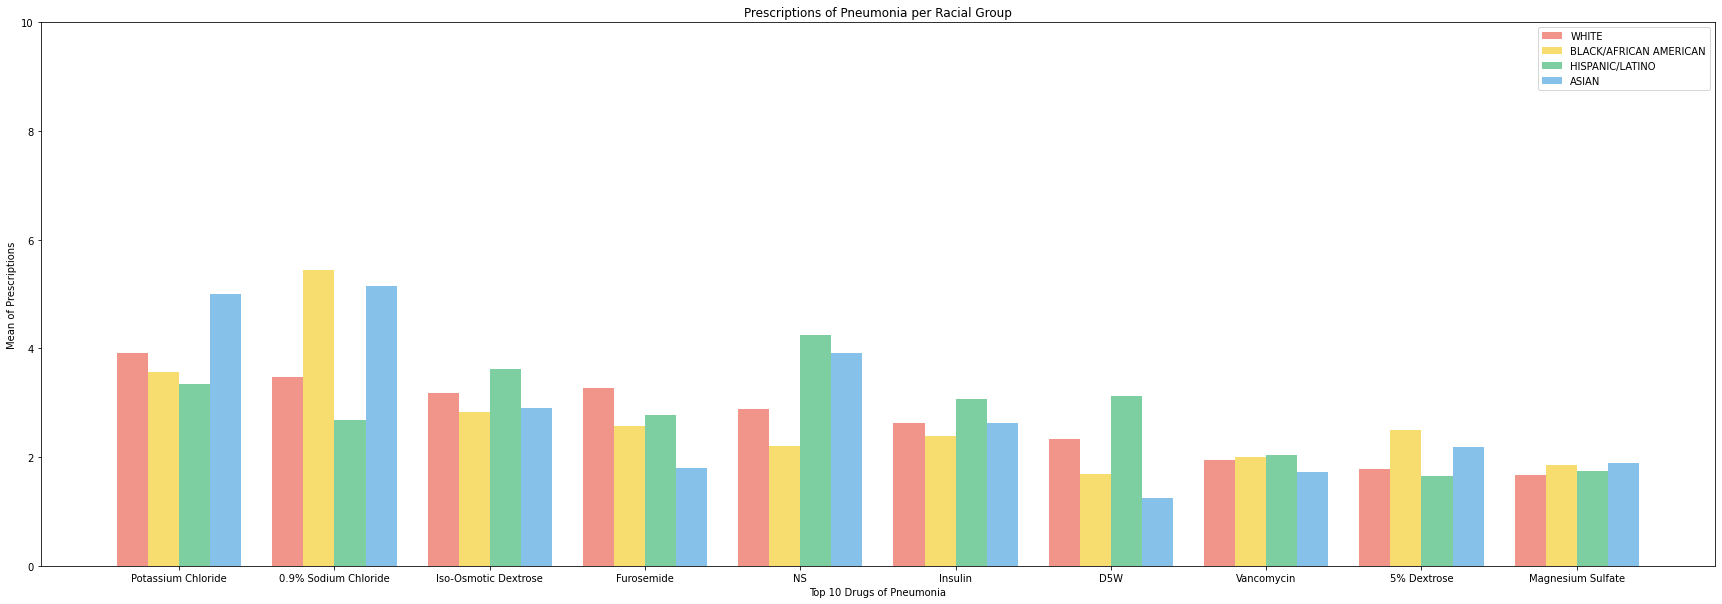


----------------------------------------Potassium Chloride----------------------------------------
                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     3.0     89.962081  29.987360  0.755362  0.519274
Residual      1233.0  48949.274782  39.699331       NaN       NaN
fvalue: 0.7553618605473144 | pvalue: 0.5192739388174246
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN  -1.4424 0.5213 -4.1684 1.2835  False
                 ASIAN        HISPANIC/LATINO  -1.6481 0.5579 -4.9198 1.6235  False
                 ASIAN                  WHITE  -1.0832 0.6524 -3.5548 1.3883  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO  -0.2057    0.9 -2.7469 2.3355  False
BLACK/AFRICAN AMERICAN                  WHITE   0.3592    

In [44]:
analysis(df_pneumonia, top_drug_df_pneumonia, 'Pneumonia')

## Sepsis

,ETHNICITY,Potassium Chloride,NS,D5W,Iso-Osmotic Dextrose,Insulin,0.9% Sodium Chloride,Furosemide,Magnesium Sulfate,SW,5% Dextrose
0,WHITE,5.570687,5.108949,4.383917,3.581064,3.511025,3.365759,2.783398,2.581064,2.450065,2.233463
1,BLACK/AFRICAN AMERICAN,3.926471,4.742647,4.058824,3.507353,3.404412,2.529412,1.698529,2.235294,1.933824,1.404412
2,HISPANIC/LATINO,2.864865,2.702703,2.000000,3.378378,2.567568,6.540541,0.972973,1.972973,0.972973,3.540541
3,ASIAN,4.678571,2.642857,1.428571,2.500000,2.000000,4.714286,1.035714,2.035714,1.535714,2.142857


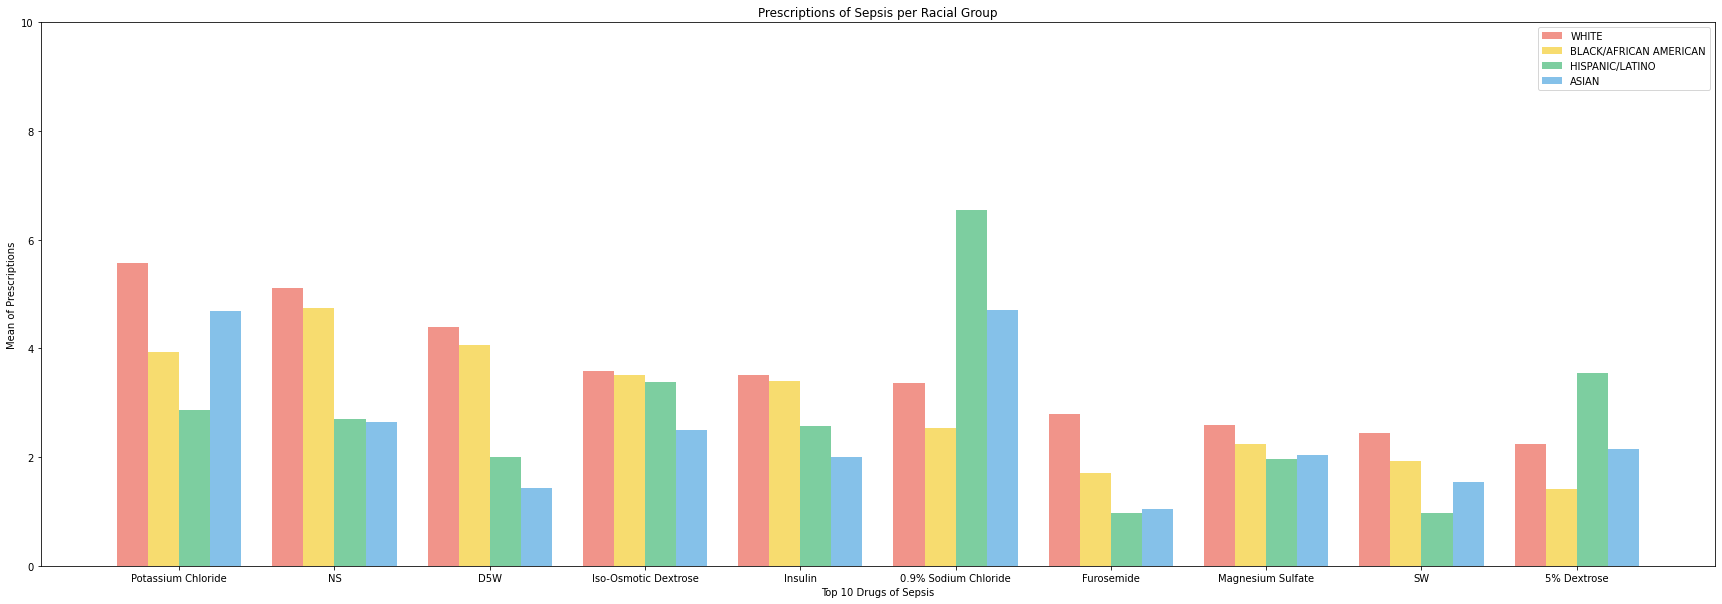


----------------------------------------Potassium Chloride----------------------------------------
                 df        sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)    3.0    535.747855  178.582618  3.010243  0.029377
Residual      968.0  57426.593709   59.324994       NaN       NaN
fvalue: 3.010242527024171 | pvalue: 0.029377430464011978
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN  -0.7521    0.9 -4.8657 3.3615  False
                 ASIAN        HISPANIC/LATINO  -1.8137 0.7576 -6.7788 3.1513  False
                 ASIAN                  WHITE   0.8921    0.9 -2.9213 4.7055  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO  -1.0616  0.868  -4.737 2.6138  False
BLACK/AFRICAN AMERICAN                  WHITE   1.6442 0.

In [45]:
analysis(df_sepsis, top_drug_df_sepsis, 'Sepsis')

## Congestive heart failure

,ETHNICITY,Furosemide,Potassium Chloride,D5W,Insulin,5% Dextrose,Sodium Chloride 0.9% Flush,NS,Metoprolol,Iso-Osmotic Dextrose,Warfarin
0,WHITE,7.944559,5.940452,5.574949,4.291581,2.096509,2.010267,1.981520,1.887064,1.850103,1.712526
1,BLACK/AFRICAN AMERICAN,5.595238,4.202381,4.386905,4.767857,1.154762,1.785714,1.839286,1.750000,1.500000,1.244048
2,HISPANIC/LATINO,7.583333,7.625000,3.291667,4.791667,3.041667,1.708333,1.750000,0.750000,1.666667,0.666667
3,ASIAN,8.533333,3.533333,2.533333,8.733333,4.666667,2.333333,1.066667,1.466667,2.000000,2.666667


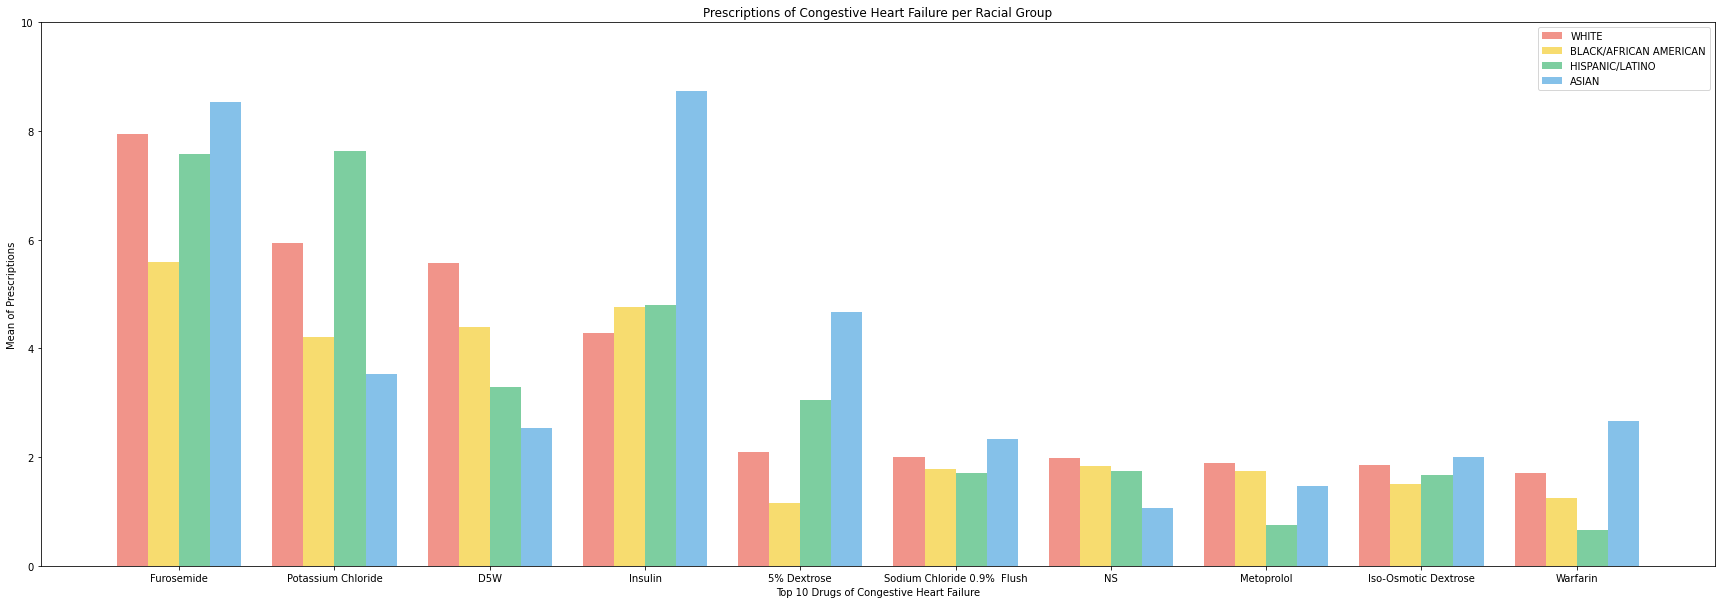


----------------------------------------Furosemide----------------------------------------
                 df        sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)    3.0    711.297002  237.099001  4.726424  0.002844
Residual      690.0  34613.545937   50.164559       NaN       NaN
fvalue: 4.726424470224596 | pvalue: 0.0028436070425063016
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN  -2.9381 0.4159 -7.8535 1.9773  False
                 ASIAN        HISPANIC/LATINO    -0.95    0.9 -6.9536 5.0536  False
                 ASIAN                  WHITE  -0.5888    0.9 -5.3704 4.1928  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO   1.9881 0.5634 -1.9923 5.9685  False
BLACK/AFRICAN AMERICAN                  WHITE   2.3493 0.0013  0

In [46]:
analysis(df_congestive_heart_failure, top_drug_df_congestive_heart_failure, 'Congestive Heart Failure')

## Coronary artery disease

,ETHNICITY,D5W,Furosemide,Potassium Chloride,Insulin,Acetaminophen,Metoprolol,Metoprolol Tartrate,Sodium Chloride 0.9% Flush,Docusate Sodium,Ranitidine
0,WHITE,5.134387,4.365613,4.071146,3.800395,3.503953,2.889328,2.820158,2.478261,2.199605,2.160079
1,BLACK/AFRICAN AMERICAN,12.428571,8.857143,7.214286,8.571429,3.214286,2.000000,2.285714,2.000000,1.785714,2.214286
2,HISPANIC/LATINO,2.076923,3.961538,3.115385,8.076923,3.730769,1.153846,5.576923,3.115385,2.538462,2.423077
3,ASIAN,3.777778,5.222222,4.111111,3.666667,4.222222,1.888889,4.777778,3.333333,2.333333,3.000000


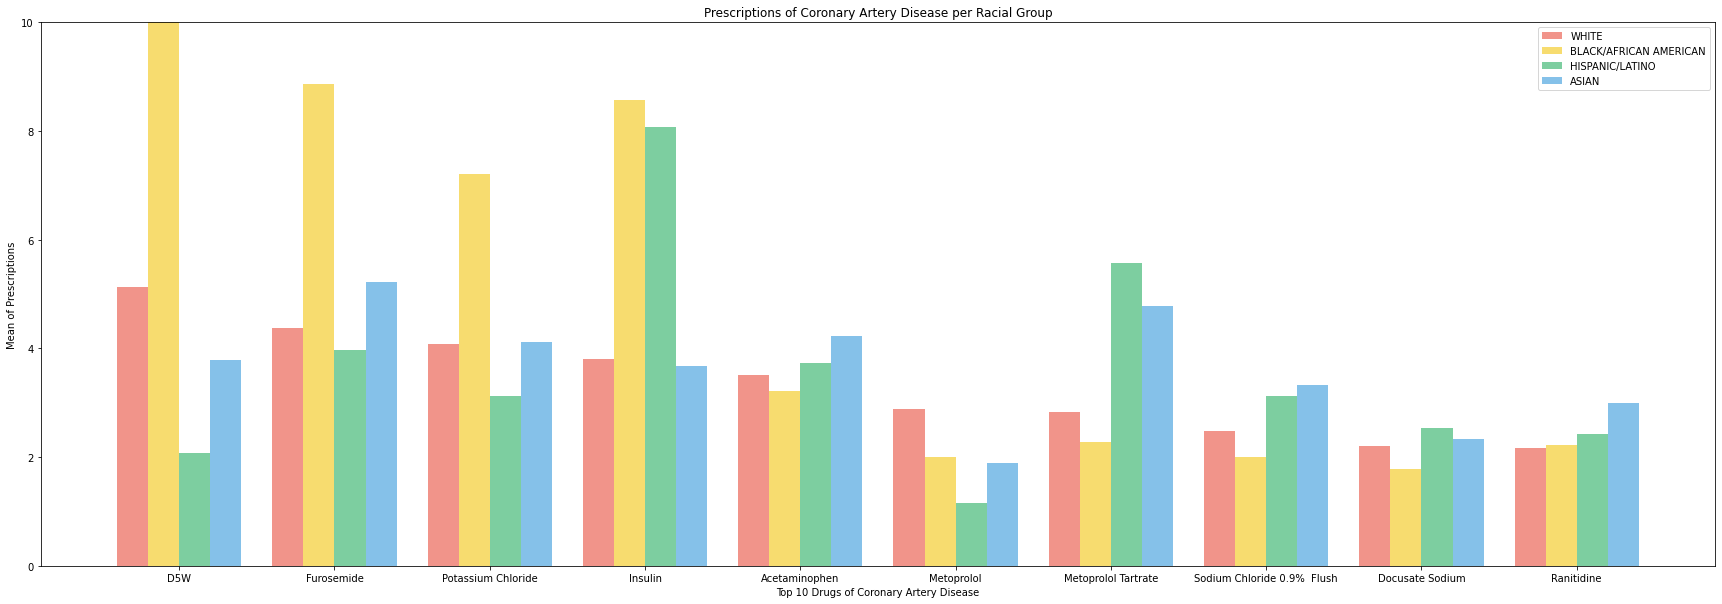


----------------------------------------D5W----------------------------------------
                 df        sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)    3.0   1004.290041  334.763347  3.471649  0.015981
Residual      551.0  53131.691941   96.427753       NaN       NaN
fvalue: 3.4716493578914327 | pvalue: 0.01598097748892142
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN   8.6508 0.1672  -2.1607 19.4622  False
                 ASIAN        HISPANIC/LATINO  -1.7009    0.9 -11.4874  8.0857  False
                 ASIAN                  WHITE   1.3566    0.9  -7.1531  9.8663  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO -10.3516 0.0084 -18.7402 -1.9631   True
BLACK/AFRICAN AMERICAN                  WHITE  -7.2942  0.

In [47]:
analysis(df_coronary_artery_disease, top_drug_df_coronary_artery_disease, 'Coronary Artery Disease')

## Chest pain

,ETHNICITY,D5W,Potassium Chloride,Furosemide,Insulin,Metoprolol Tartrate,Sodium Chloride 0.9% Flush,Acetaminophen,Metoprolol,5% Dextrose,Heparin
0,WHITE,3.853565,3.909441,3.768786,3.113680,2.707129,2.292871,2.256262,2.077071,1.701349,1.703276
1,BLACK/AFRICAN AMERICAN,3.100000,3.328571,2.685714,6.028571,1.985714,2.128571,1.628571,1.457143,2.342857,2.042857
2,HISPANIC/LATINO,1.708333,3.083333,1.833333,4.541667,1.041667,1.708333,1.625000,1.291667,1.333333,1.166667
3,ASIAN,2.631579,2.947368,1.578947,0.684211,2.421053,2.894737,2.052632,1.684211,3.000000,1.315789


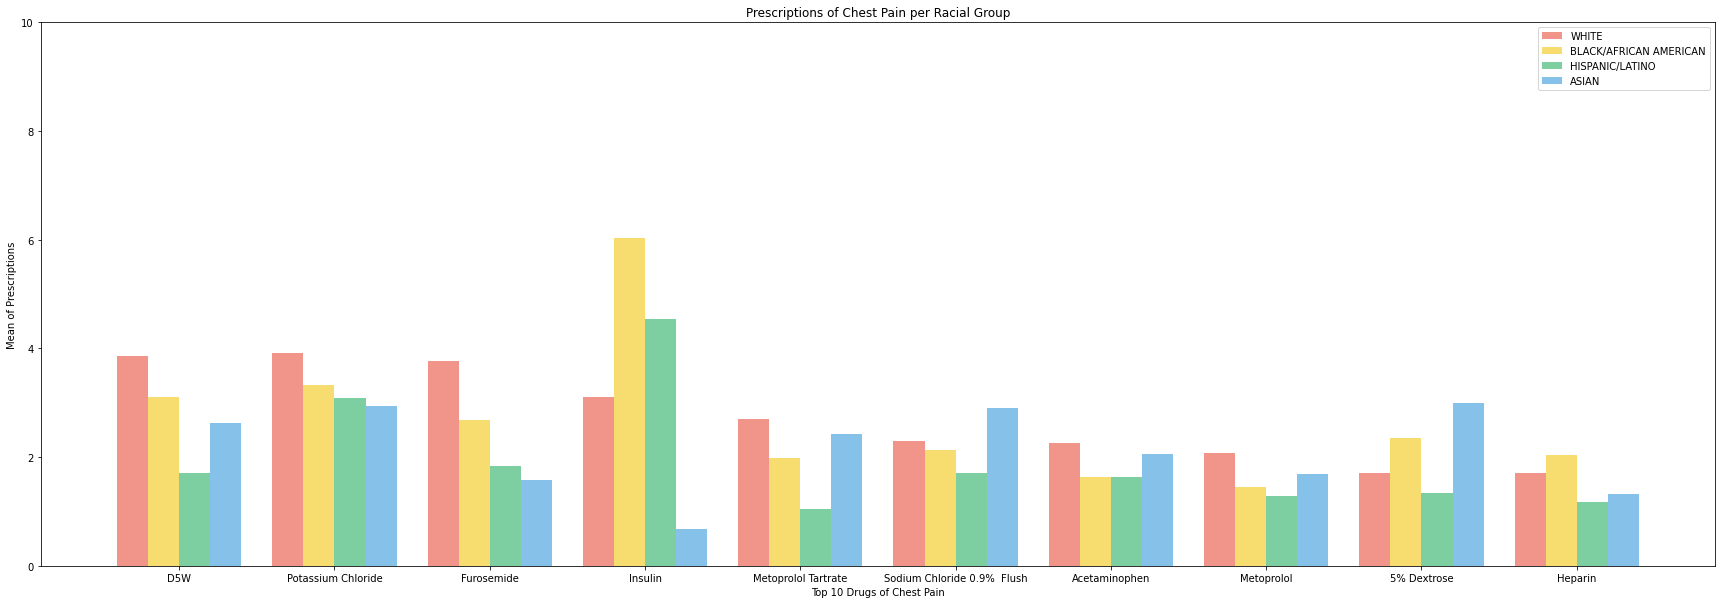


----------------------------------------D5W----------------------------------------
                 df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)    3.0    152.867430  50.955810  1.620385  0.183405
Residual      628.0  19748.550292  31.446736       NaN       NaN
fvalue: 1.6203846966253428 | pvalue: 0.18340507632920033
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN   0.4684    0.9 -3.2684 4.2052  False
                 ASIAN        HISPANIC/LATINO  -0.9232    0.9 -5.3591 3.5126  False
                 ASIAN                  WHITE    1.222 0.7617 -2.1521 4.5961  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO  -1.3917 0.6965 -4.8086 2.0253  False
BLACK/AFRICAN AMERICAN                  WHITE   0.7536  0.693 -1.0857 2.592

In [48]:
analysis(df_chest_pain, top_drug_df_chest_pain, 'Chest Pain')

## Intracranial hemorrhage

,ETHNICITY,0.9% Sodium Chloride,Potassium Chloride,Insulin,NS,Sodium Chloride 0.9% Flush,Magnesium Sulfate,Metoprolol Tartrate,SW,Acetaminophen,5% Dextrose
0,WHITE,4.578189,4.176955,2.500000,2.310700,1.786008,1.701646,1.744856,1.646091,1.582305,1.290123
1,BLACK/AFRICAN AMERICAN,4.657143,5.800000,3.914286,2.400000,2.200000,1.657143,1.428571,2.485714,1.542857,1.857143
2,HISPANIC/LATINO,7.250000,6.375000,2.916667,3.458333,2.208333,2.791667,2.500000,2.625000,1.833333,3.375000
3,ASIAN,3.681818,2.500000,1.681818,1.409091,2.090909,1.772727,0.227273,1.181818,0.909091,0.909091


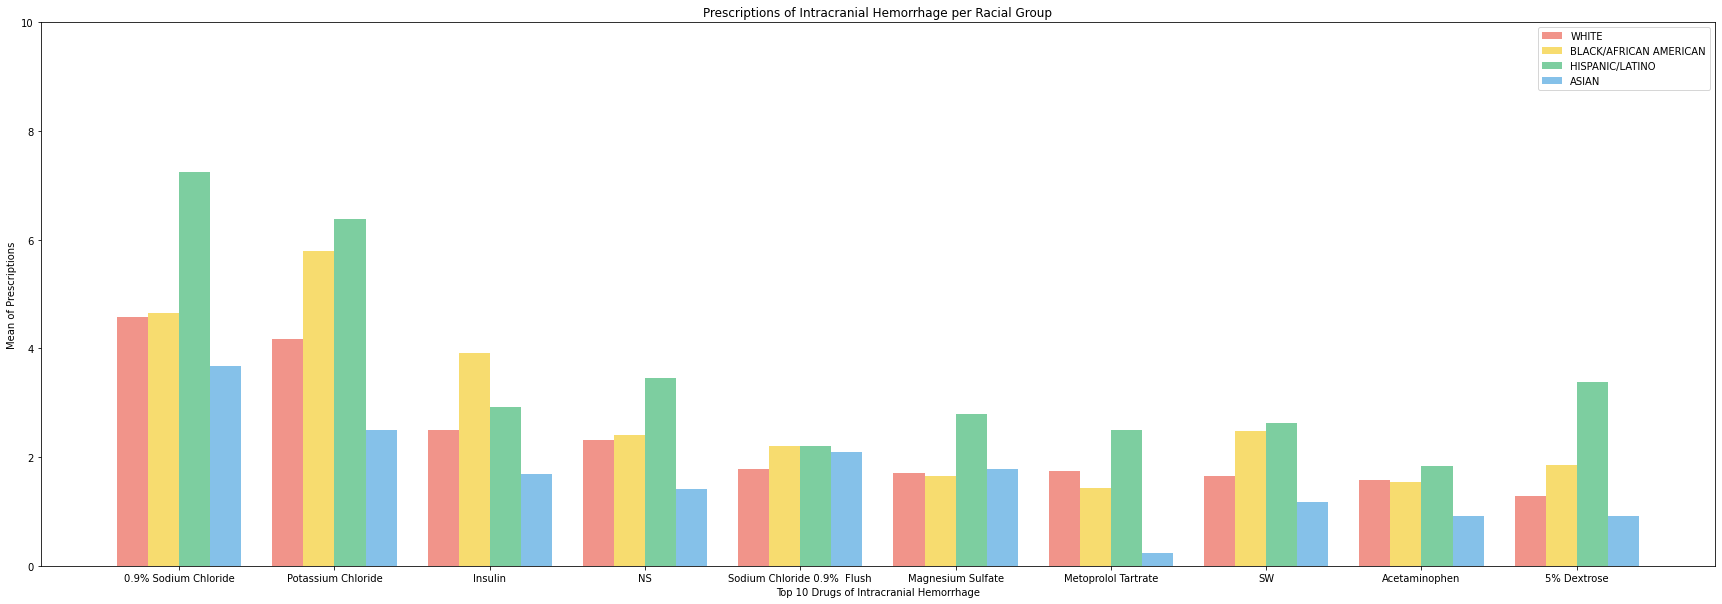


----------------------------------------0.9% Sodium Chloride----------------------------------------
                 df        sum_sq    mean_sq        F    PR(>F)
C(ETHNICITY)    3.0    185.296879  61.765626  1.39399  0.243661
Residual      563.0  24945.687248  44.308503      NaN       NaN
fvalue: 1.393990361940309 | pvalue: 0.24366130603149586
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN   0.9753    0.9 -3.6914  5.642  False
                 ASIAN        HISPANIC/LATINO   3.5682 0.2669 -1.4945 8.6309  False
                 ASIAN                  WHITE   0.8964    0.9 -2.8423 4.6351  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO   2.5929 0.4578 -1.9529 7.1386  False
BLACK/AFRICAN AMERICAN                  WHITE   -0.079    0.9 

In [49]:
analysis(df_intracranial_hemorrhage, top_drug_df_intracranial_hemorrhage, 'Intracranial Hemorrhage')

## Altered mental status

,ETHNICITY,0.9% Sodium Chloride,Potassium Chloride,Insulin,Iso-Osmotic Dextrose,NS,5% Dextrose,Sodium Chloride 0.9% Flush,Furosemide,Magnesium Sulfate,Lorazepam
0,WHITE,4.138889,3.914530,2.502137,2.333333,2.179487,2.006410,1.822650,1.634615,1.576923,1.611111
1,BLACK/AFRICAN AMERICAN,4.500000,3.735849,4.603774,2.566038,2.698113,2.481132,2.103774,1.726415,1.924528,1.245283
2,HISPANIC/LATINO,4.172414,3.896552,2.586207,2.103448,3.413793,2.206897,1.965517,2.448276,2.068966,2.206897
3,ASIAN,3.545455,2.909091,6.272727,2.363636,2.545455,1.090909,1.454545,2.000000,2.000000,1.090909


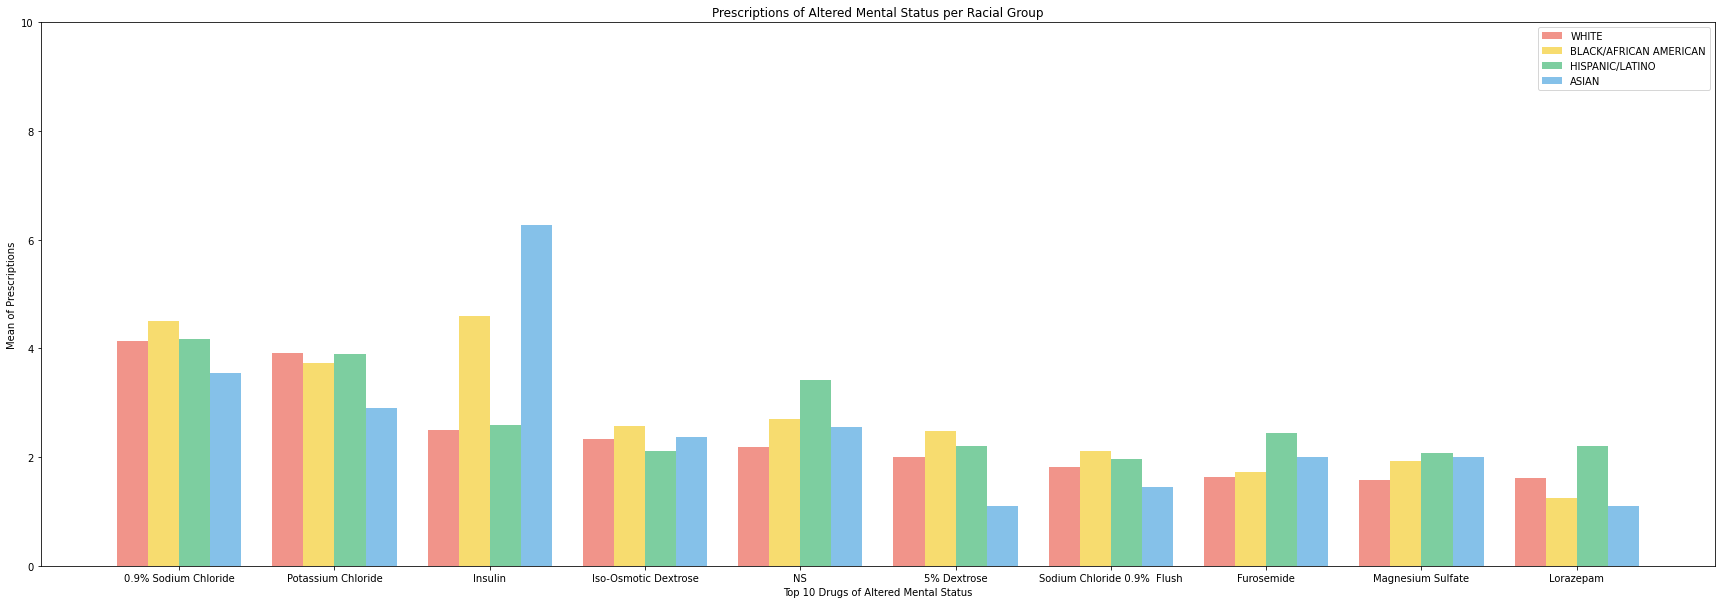


----------------------------------------0.9% Sodium Chloride----------------------------------------
                 df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)    3.0     15.985050   5.328350  0.100345  0.959802
Residual      610.0  32391.337426  53.100553       NaN       NaN
fvalue: 0.10034452647280356 | pvalue: 0.9598015362326363
               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj  lower  upper  reject
----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN   0.9545   0.9  -4.992 6.9011  False
                 ASIAN        HISPANIC/LATINO    0.627   0.9 -6.0206 7.2745  False
                 ASIAN                  WHITE   0.5934   0.9 -5.1329 6.3197  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO  -0.3276   0.9 -4.2616 3.6065  False
BLACK/AFRICAN AMERICAN                  WHITE  -0.3611   0.9 -2.3

In [50]:
analysis(df_altered_mental_status, top_drug_df_altered_mental_status, 'Altered Mental Status')

## Gastrointestinal bleed

,ETHNICITY,Potassium Chloride,NS,D5W,Magnesium Sulfate,Furosemide,0.9% Sodium Chloride,Insulin,SW,Sodium Chloride 0.9% Flush,Pantoprazole
0,WHITE,3.600939,3.298122,2.103286,2.035211,1.845070,1.744131,1.453052,1.544601,1.495305,1.342723
1,BLACK/AFRICAN AMERICAN,3.298246,3.543860,1.403509,1.649123,1.982456,1.912281,3.771930,0.947368,1.263158,1.157895
2,HISPANIC/LATINO,2.785714,2.357143,1.071429,1.642857,1.142857,2.071429,1.642857,1.214286,1.071429,1.428571
3,ASIAN,2.052632,1.421053,0.368421,0.736842,0.789474,1.368421,0.578947,0.526316,1.052632,1.368421


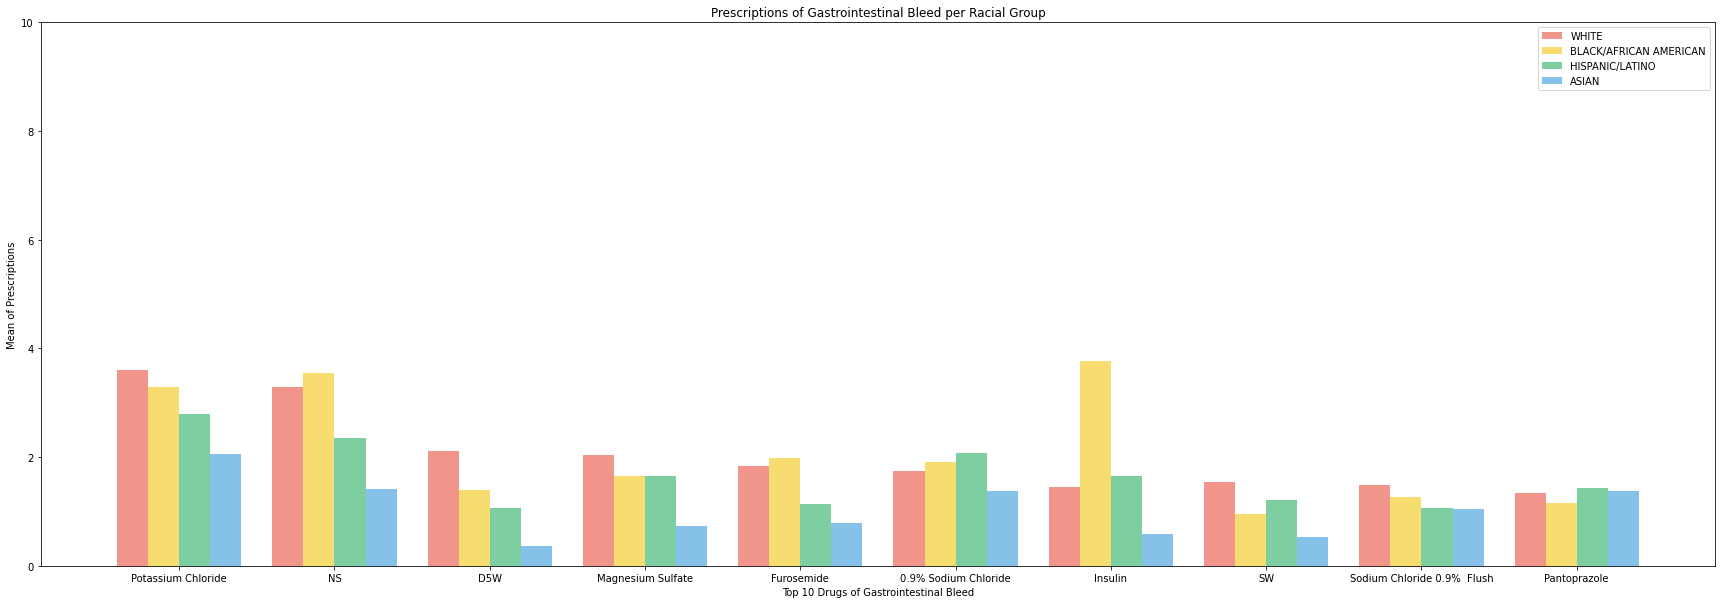


----------------------------------------Potassium Chloride----------------------------------------
                 df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)    3.0     53.536272  17.845424  0.571289  0.634119
Residual      512.0  15993.393960  31.237098       NaN       NaN
fvalue: 0.5712894438058572 | pvalue: 0.634119473538197
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN   1.2456 0.8131 -2.5706 5.0618  False
                 ASIAN        HISPANIC/LATINO   0.7331    0.9  -4.341 5.8072  False
                 ASIAN                  WHITE   1.5483 0.6224 -1.8295 4.9262  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO  -0.5125    0.9 -4.8096 3.7845  False
BLACK/AFRICAN AMERICAN                  WHITE   0.3027    0.9 

In [51]:
analysis(df_gastrointestinal_bleed, top_drug_df_gastrointestinal_bleed, 'Gastrointestinal Bleed')

## Coronary artery disease coronary artery bypass graft sda

,ETHNICITY,Metoprolol Tartrate,Furosemide,Acetaminophen,Potassium Chloride,Insulin,Ranitidine,0.9% Sodium Chloride,Morphine Sulfate,Sodium Chloride 0.9% Flush,Docusate Sodium
0,WHITE,3.754923,3.682713,3.542670,3.428884,3.343545,2.647702,2.507659,2.190372,2.133479,2.063457
1,BLACK/AFRICAN AMERICAN,2.882353,3.529412,3.235294,3.352941,5.352941,3.000000,1.117647,1.823529,1.529412,1.941176
2,HISPANIC/LATINO,4.680000,3.160000,3.320000,3.160000,3.160000,2.800000,3.040000,1.720000,2.440000,2.120000
3,ASIAN,3.387097,2.967742,3.322581,3.354839,2.129032,2.483871,2.516129,2.000000,2.096774,2.096774


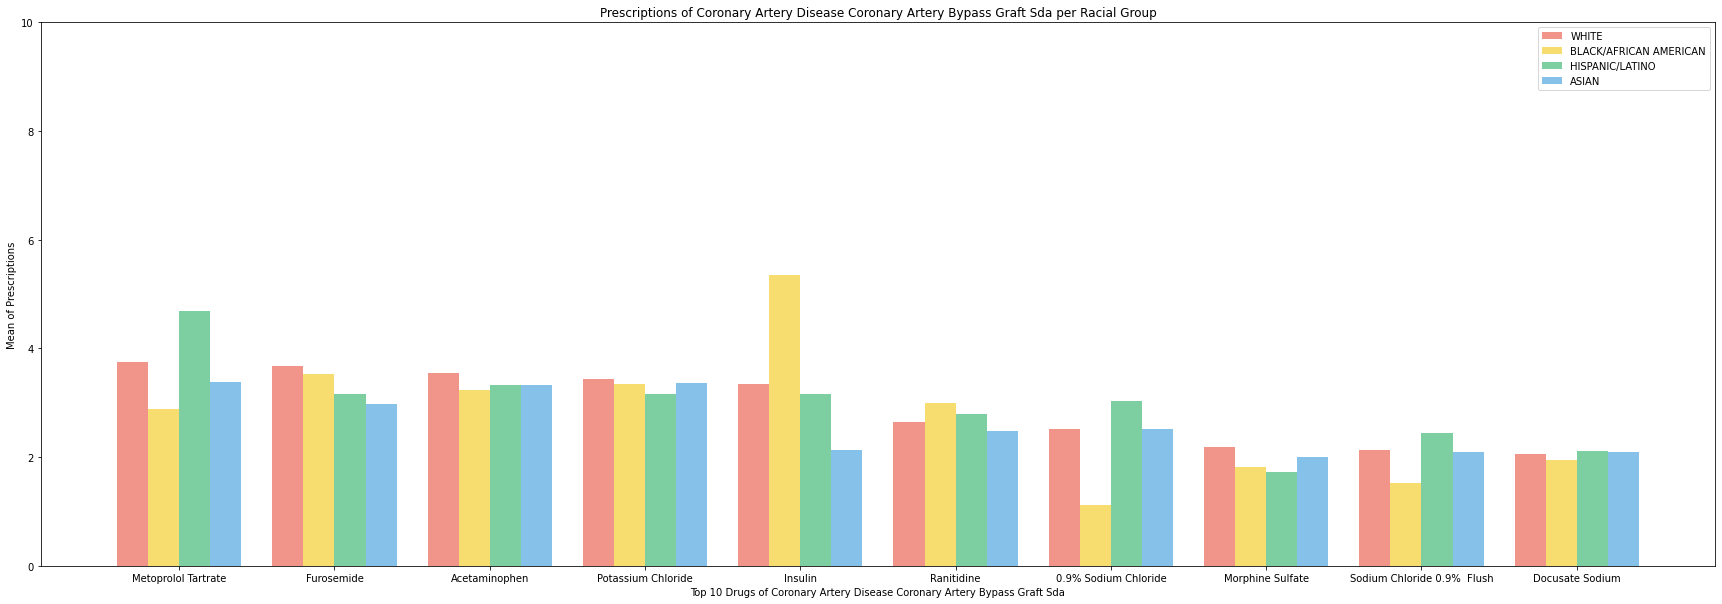


----------------------------------------Metoprolol Tartrate----------------------------------------
                 df       sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)    3.0    38.513561  12.837854  1.054269  0.368144
Residual      526.0  6405.110967  12.177017       NaN       NaN
fvalue: 1.0542691815954088 | pvalue: 0.3681444843602196
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN  -0.5047    0.9  -3.219 2.2095  False
                 ASIAN        HISPANIC/LATINO   1.2929  0.512 -1.1247 3.7105  False
                 ASIAN                  WHITE   0.3678    0.9 -1.3014  2.037  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO   1.7976 0.3583 -1.0296 4.6249  False
BLACK/AFRICAN AMERICAN                  WHITE   0.8726 0.7172 -

In [52]:
analysis(df_coronary_artery_disease_coronary_artery_bypass_graft_sda, top_drug_df_coronary_artery_disease_coronary_artery_bypass_graft_sda, 'Coronary Artery Disease Coronary Artery Bypass Graft Sda')

## Upper GI bleed

,ETHNICITY,0.9% Sodium Chloride,Potassium Chloride,Insulin,Pantoprazole,NS,Sodium Chloride 0.9% Flush,Magnesium Sulfate,Vial,5% Dextrose,Iso-Osmotic Dextrose
0,WHITE,3.591029,2.617414,1.593668,1.781003,1.939314,1.696570,1.585752,1.218997,1.163588,1.160950
1,BLACK/AFRICAN AMERICAN,4.076923,2.430769,2.938462,2.046154,1.092308,1.507692,1.353846,1.261538,1.292308,1.107692
2,HISPANIC/LATINO,3.656250,2.125000,3.343750,1.718750,0.718750,1.625000,1.281250,1.156250,1.312500,0.781250
3,ASIAN,2.720000,1.560000,1.080000,1.760000,1.920000,1.600000,0.800000,1.240000,0.600000,0.560000


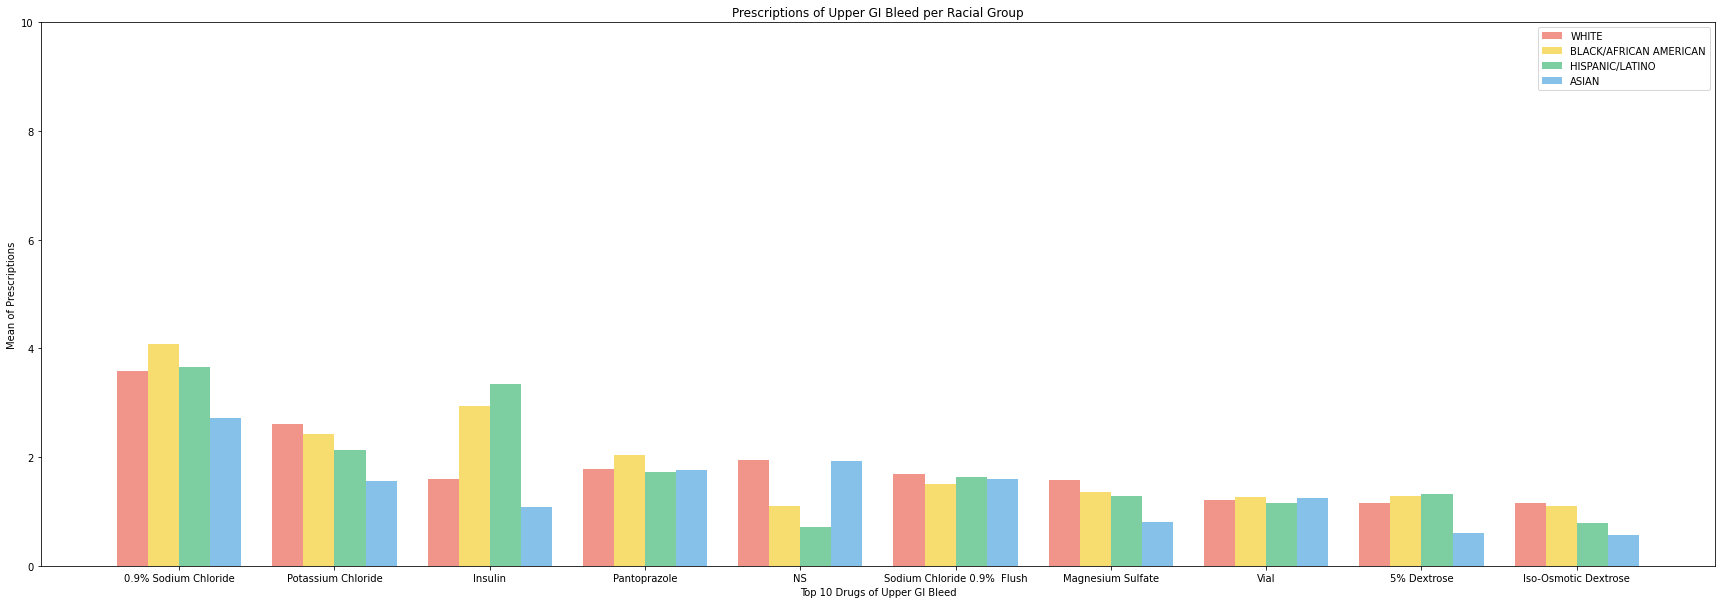


----------------------------------------0.9% Sodium Chloride----------------------------------------
                 df        sum_sq    mean_sq        F    PR(>F)
C(ETHNICITY)    3.0     34.167065  11.389022  0.39014  0.760155
Residual      497.0  14508.483633  29.192120      NaN       NaN
fvalue: 0.3901402766963419 | pvalue: 0.760155350992849
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
                 ASIAN BLACK/AFRICAN AMERICAN   1.3569 0.6865 -1.9208 4.6347  False
                 ASIAN        HISPANIC/LATINO   0.9362    0.9 -2.7815  4.654  False
                 ASIAN                  WHITE    0.871 0.8471 -2.0049  3.747  False
BLACK/AFRICAN AMERICAN        HISPANIC/LATINO  -0.4207    0.9 -3.4284  2.587  False
BLACK/AFRICAN AMERICAN                  WHITE  -0.4859    0.9 -

In [53]:
analysis(df_upper_gi_bleed, top_drug_df_upper_gi_bleed, 'Upper GI Bleed')